
# Avection with anisotropic diffusion

#### Neumann boundary conditions

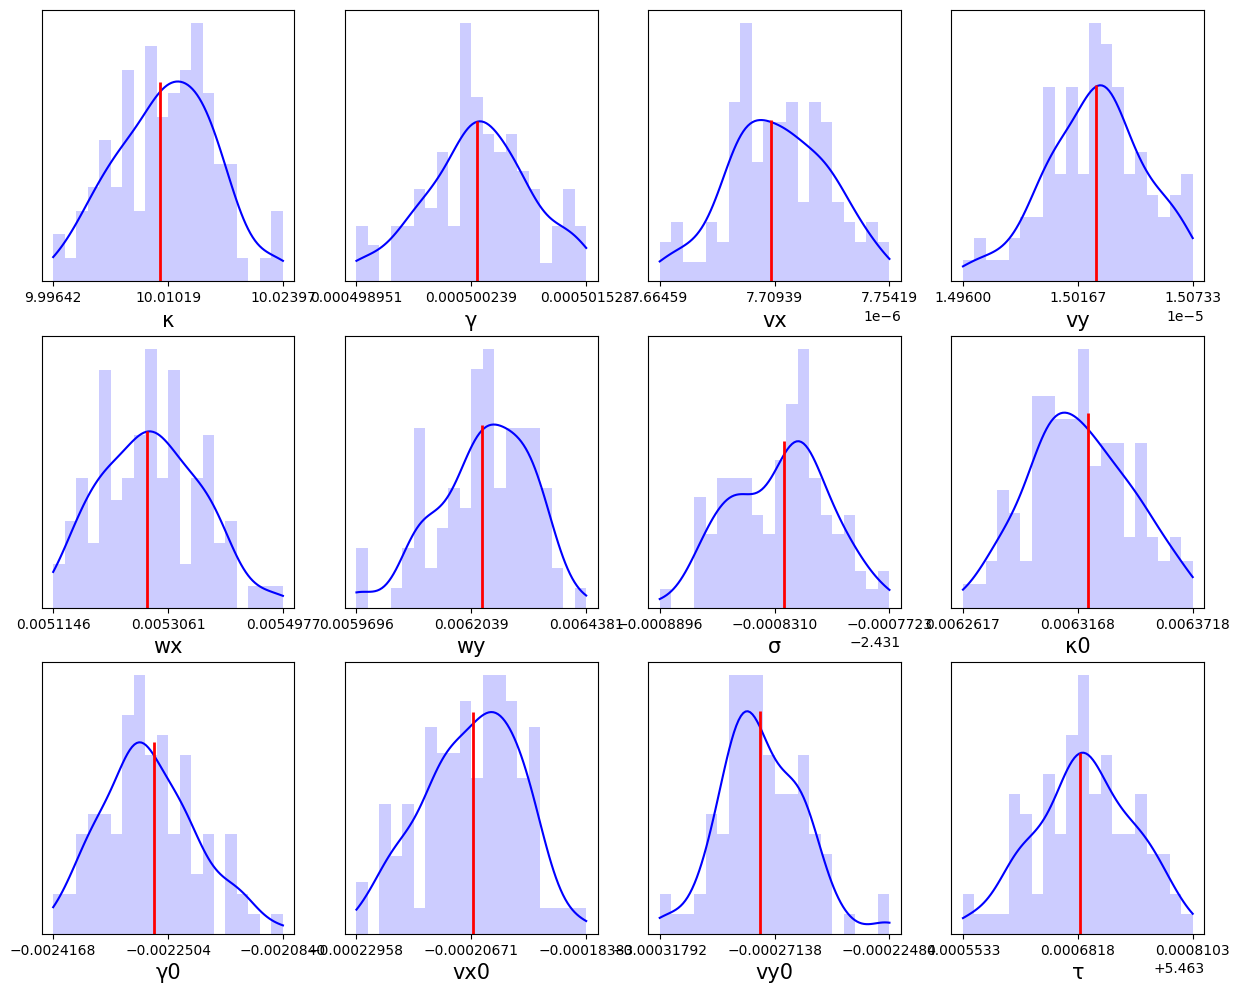

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/advection-diffusion-2D-bc1.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 4
n = 3
fig, ax = plt.subplots(figsize = (15,12),ncols = m, nrows = n)
titles = np.array(["\u03BA", "\u03B3", "vx" ,"vy", "wx" ,"wy", "\u03C3", "\u03BA0", "\u03B30", "vx0" ,"vy0", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 15)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
        

### Dirichlet boundary conditions

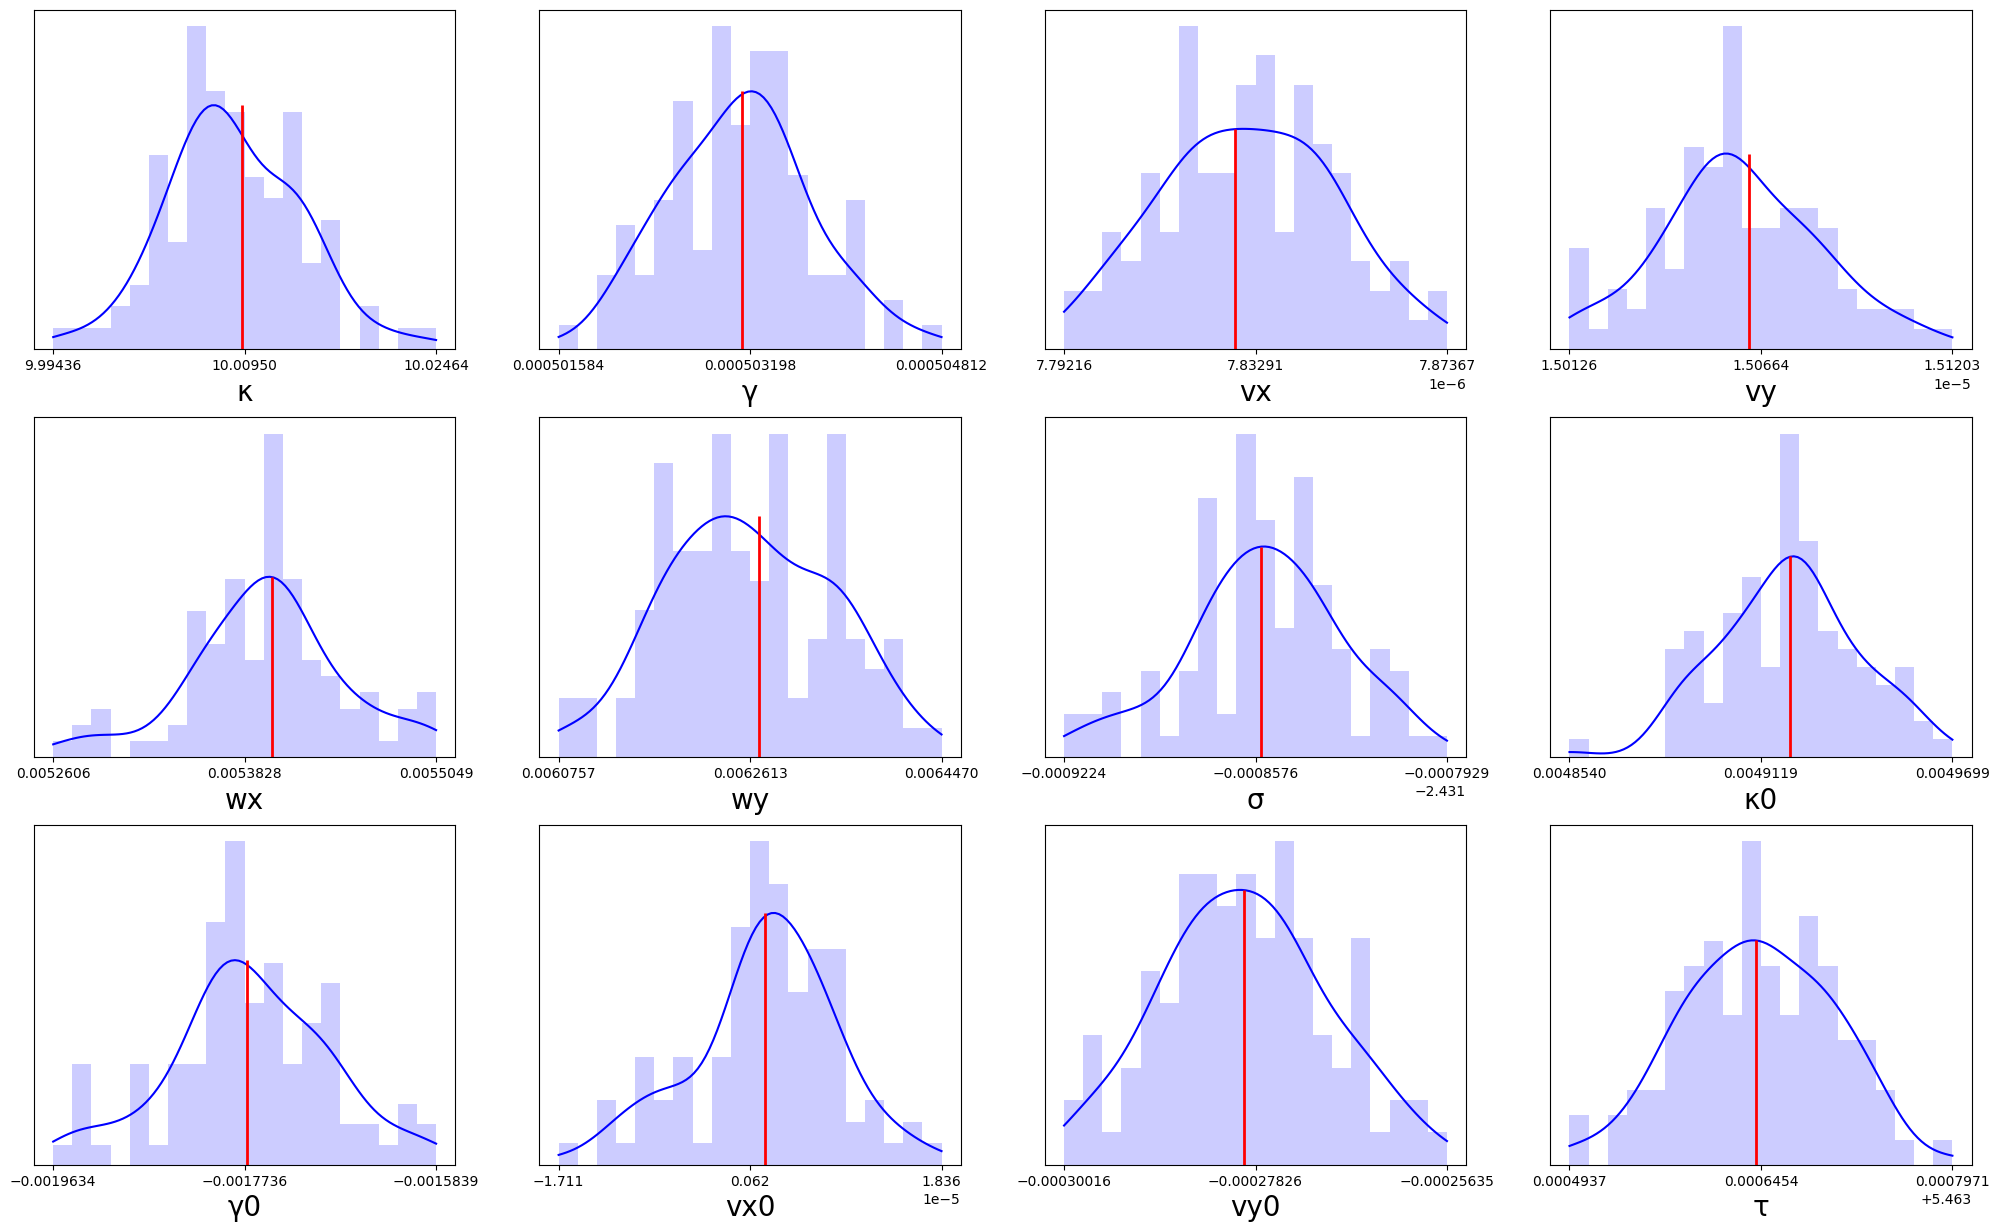

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/advection-diffusion-2D-bc3.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 4
n = 3
fig, ax = plt.subplots(figsize = (25,15),ncols = m, nrows = n)
titles = np.array(["\u03BA", "\u03B3", "vx" ,"vy", "wx" ,"wy", "\u03C3","\u03BA0", "\u03B30", "vx0" ,"vy0","\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 20)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
        

#### Visulization

In [1]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
spde = 'advection-diffusion'
mod0 = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_ani_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = True)
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], t = data['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = True, mod0 = mod0,
        parameters = np.load('../fits/advection_diffusion_ani_bc%d.npy'%(bc)))
mod.setModel(mu = data['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = True)


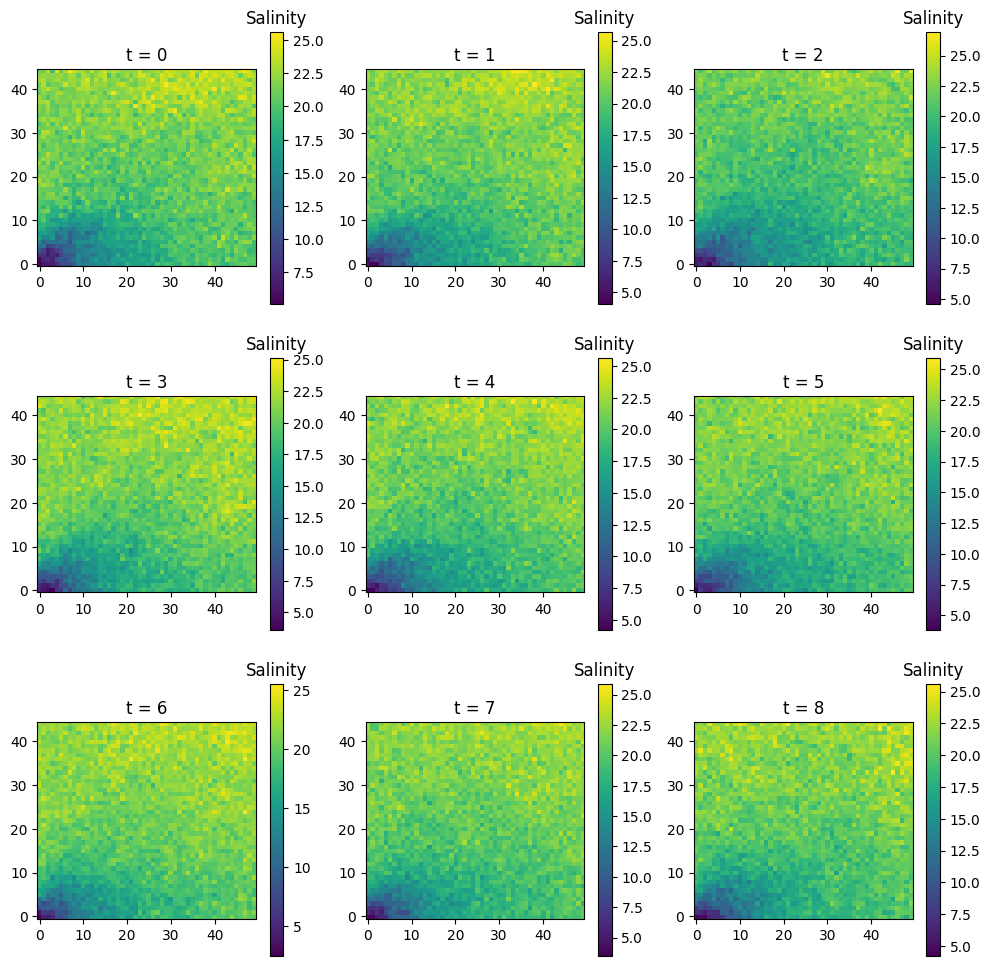

In [2]:
tmp = mod.sample().reshape(mod.grid.T,mod.grid.N,mod.grid.M)
im = list()
clb = list()
fig,ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12,12))
for i in range(3):
    for j in range(3):
        im.append(ax[i,j].imshow(tmp[i*3 + j,:,:],origin = 'lower'))
        clb.append(fig.colorbar(im[i*3+j],ax = ax[i,j]))
        clb[i*3 + j].ax.set_title('Salinity')
        ax[i,j].set_title('t = %d'%(i*3+j))
#fig.tight_layout()

#### Pred

- Fix RMSE to only count forcast error

In [1]:
import spdepy as sp
import numpy as np
from scipy import sparse
from tqdm import tqdm
import matplotlib.pyplot as plt

dataTe = sp.datasets.get_sinmod_test()
dataTr = sp.datasets.get_sinmod_training()
bc = 1
spde = 'advection-diffusion'
mod0 = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_ani_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = True)
mod = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], t = dataTr['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q,
        parameters = np.load('../fits/advection_diffusion_ani_bc%d.npy'%(bc)))
mod.setQ()


In [2]:
tmp = sp.datasets.get_sinmod_validation()

In [3]:
tmp['dataS'].shape

(2250, 10, 72)

28.655026891893865


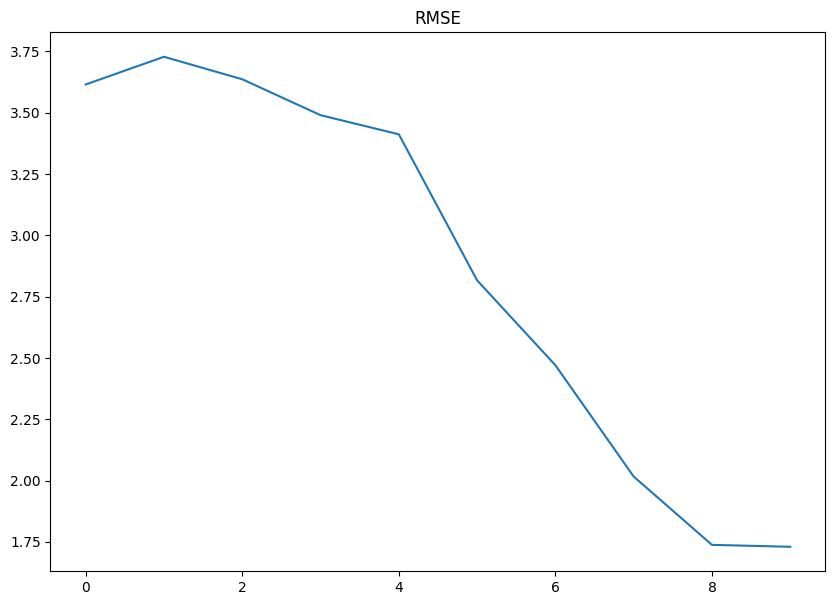

In [10]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = False)
res = np.zeros(10)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values

res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(9):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    rmF = np.stack([tidx == (start+t) for t in range(k+1,10)],axis= 1)
    idxsF = np.hstack([idx[rmF[:,t-k-1]] + mod.grid.N*mod.grid.M*(t) for t in range(k+1,10)])
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k-1]] for t in range(k+1,10)]))**2))

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(10,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())


35.30087697842573


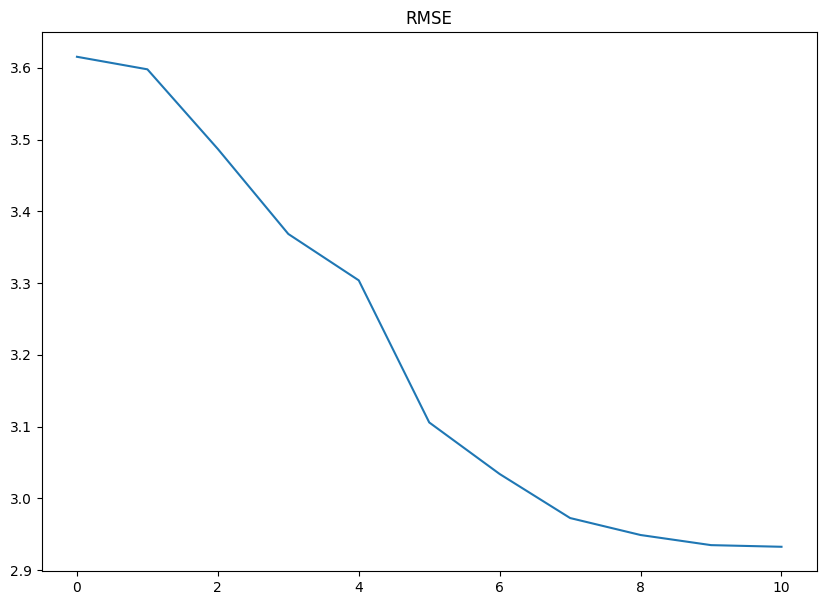

In [11]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = False)
res = np.zeros(11)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values
res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(10):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(11,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())

30.62268695493562


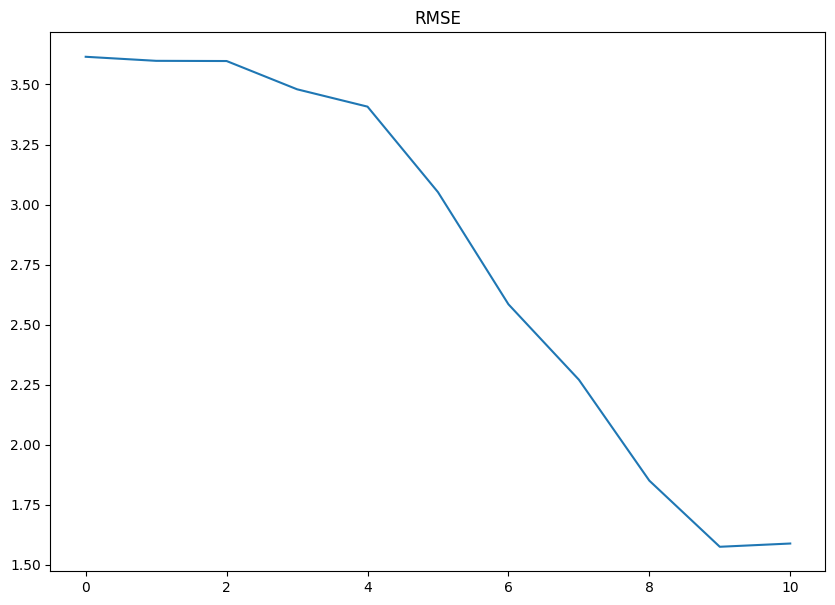

In [12]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = False)
res = np.zeros(11)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values
res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(10):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    rmF = np.stack([tidx == (start+t) for t in range(k,10)],axis= 1)
    idxsF = np.hstack([idx[rmF[:,t-k]] + mod.grid.N*mod.grid.M*(t) for t in range(k,10)])
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k]] for t in range(k,10)]))**2))
    
fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(11,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())


### With covariates

In [13]:
import spdepy as sp
import numpy as np
from scipy import sparse
from tqdm import tqdm
import matplotlib.pyplot as plt

dataTe = sp.datasets.get_sinmod_test()
dataTr = sp.datasets.get_sinmod_training()
bc = 1
spde = 'advection-diffusion'
mod0 = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_ani_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = True)
mod = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], t = dataTr['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q,
        parameters = np.load('../fits/advection_diffusion_ani_bc%d.npy'%(bc)))
mod.setQ()

Text(0.5, 1.0, 'RMSE')

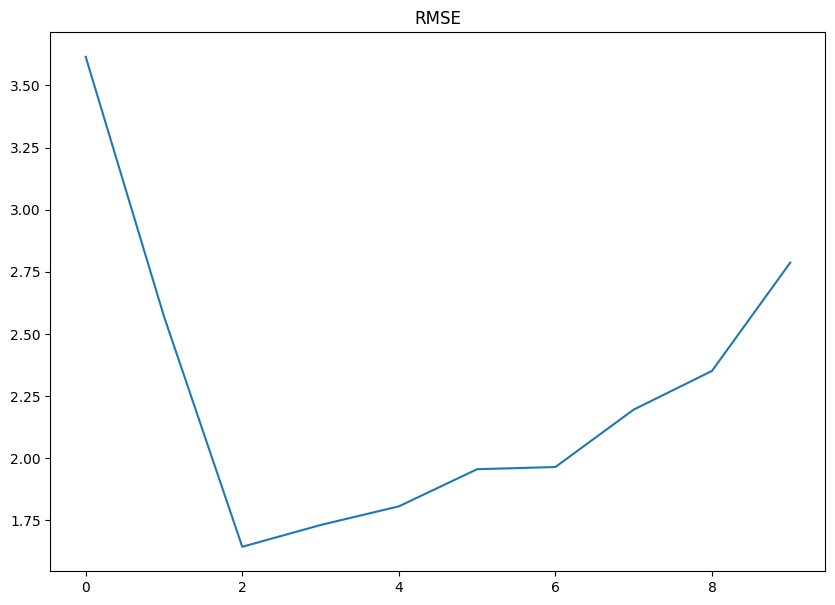

In [14]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = True)
res = np.zeros(10)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values

res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(9):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    rmF = np.stack([tidx == (start+t) for t in range(k+1,10)],axis= 1)
    idxsF = np.hstack([idx[rmF[:,t-k-1]] + mod.grid.N*mod.grid.M*(t) for t in range(k+1,10)])
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k-1]] for t in range(k+1,10)]))**2))

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(10,dtype = "int32"),res,'-')
ax.set_title('RMSE')


In [8]:
import numpy as np
np.load("../fits/sinmod/sigmas.npy")

array([0.70507248, 0.01295507])

In [105]:
res = np.zeros(10)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values
idxsL = list()
k = 0

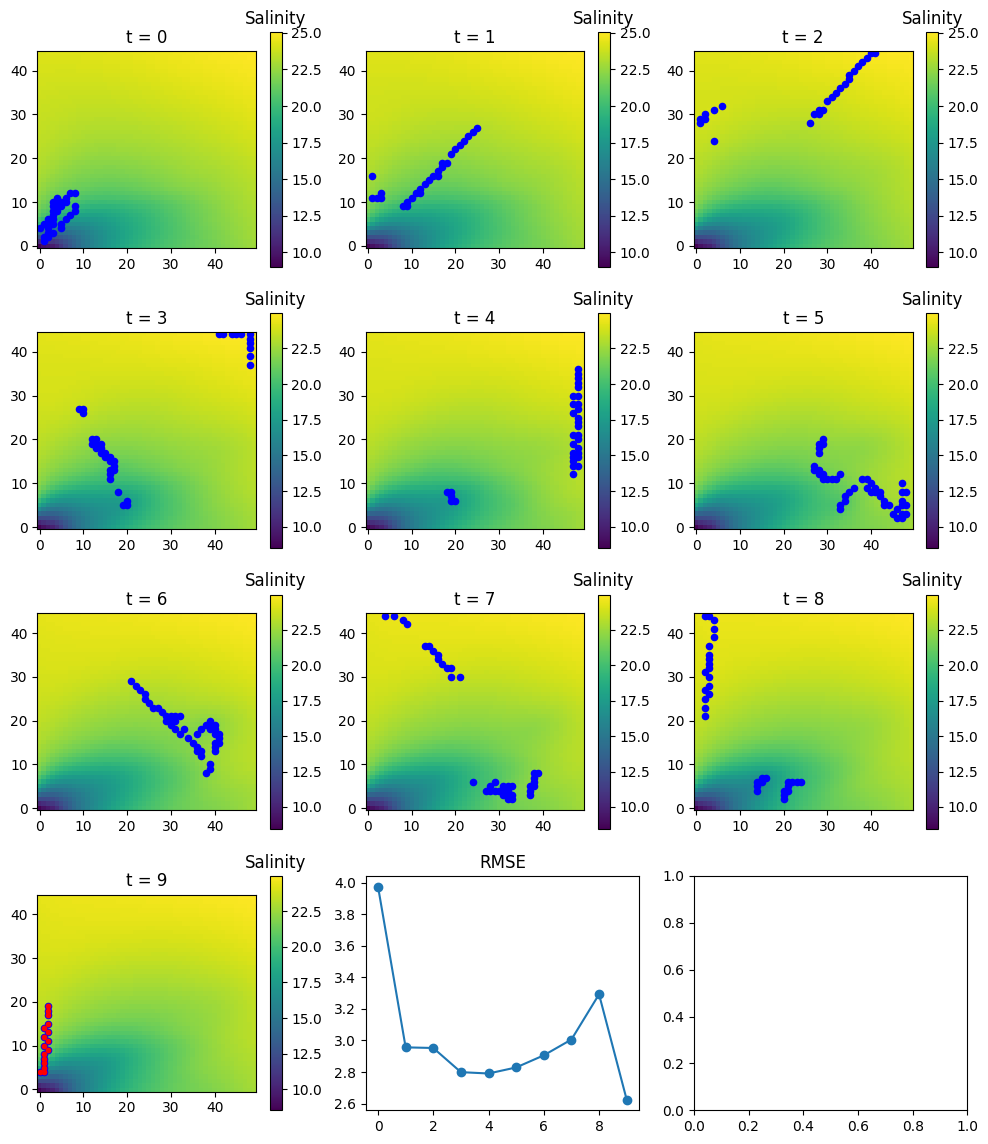

In [115]:



rm = tidx == (start+k)
idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
idxsL.append(idxs)
mod.update(y = data[rm], idx = idxs,tau = tau)
rmF = np.stack([tidx == (start+t) for t in range(k,10)],axis= 1)
idxsF = np.hstack([idx[rmF[:,t-k]] + mod.grid.N*mod.grid.M*(t) for t in range(k,10)])
idxsF2 = [idx[rmF[:,t-k]] + mod.grid.N*mod.grid.M*(t) for t in range(k,10)]
res[k] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k]] for t in range(k,10)]))**2))
tmp = (mod.grid.getS()@mod.mu).reshape(mod.grid.T,mod.grid.N,mod.grid.M)
#tmp = mod.sample(n=100).var(axis = 1).reshape(mod.grid.T,mod.grid.N,mod.grid.M)
im = list()
clb = list()
fig,ax = plt.subplots(ncols = 3, nrows = 4, figsize = (12,14))
for i in range(4):
    for j in range(3):
        if i*3 + j + 1 == 11:
            ax[i,j].plot(np.arange(k+1,dtype = "int32"),res[:(k+1)],'o-')
            ax[i,j].set_title('RMSE')
            break
        im.append(ax[i,j].imshow(tmp[i*3 + (j),:,:],origin = 'lower'))
        t2 = tidx == (start+i*3 + j)
        if i*3 + j <= k:
            ax[i,j].scatter(mod.grid.ix[idxsL[i*3+j]],mod.grid.iy[idxsL[i*3+j]],s = 20,c = "blue")
        if i*3 + j >= k:
            ax[i,j].scatter(mod.grid.ix[idxsF2[i*3+j-k]],mod.grid.iy[idxsF2[i*3+j-k]],s = 10,c = "red")
        clb.append(fig.colorbar(im[i*3],ax = ax[i,j]))
        clb[i*3 + j].ax.set_title('Salinity')
        ax[i,j].set_title('t = %d'%(i*3+j))

k += 1

In [134]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = True)


In [135]:
mod.update(y = np.array([2,4,6,8,10,12])+10, idx = [1234,2345,3456,4567,5678,6789],tau = 1000)

In [136]:
mod.grid.getS(idxs = [1234,2345,3456,4567,5678,6789])@mod.mu

array([12.06677213, 14.02266107, 15.99824731, 17.98293457, 19.96554669,
       21.9576651 ])

In [123]:
mod.grid.getS(idxs = [1234,2345,3456,4567,5678,6789])@mod.mu

array([26.94193229, 25.74935393, 26.4338653 , 20.96895078, 26.55373569,
       24.93015418])